In [152]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import itertools
from keras.backend import clear_session
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import keras
import gensim.downloader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

plt.style.use('ggplot')
#nltk.download('wordnet')
#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [153]:
with open('./data.txt') as f:
    sentences=[line[:-1].split(";") for line in f.readlines()]
sentences[1999][1]='fear'

In [154]:
df=pd.DataFrame(sentences)
df=df.rename(columns={0:"sentence",1:"emotion"})

set(df["emotion"])
dic={'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}
df['emotion']=[*map(dic.get, df['emotion'])]

In [155]:
def remove_symbols(sentence):
	return sentence.replace("""!"#$%&'()*+,،-./:;<=>1234567890؟?@[\]^_`{|}~""","")

def lowercase(sentence):
	return sentence.lower()

lemmatizer=WordNetLemmatizer()
def lemmatize(sentence):
	return " ".join([lemmatizer.lemmatize(word) for word in sentence.split(" ")])

def remove_stopwords(sentence):
	return " ".join([word for word in sentence.split(" ") if word not in stop_words])

df.sentence=df.sentence.apply(remove_symbols)
df.sentence=df.sentence.apply(lowercase)
df.sentence=df.sentence.apply(remove_stopwords)
df.sentence=df.sentence.apply(lemmatize)

In [156]:
sentences_train, sentences_test, emotion_train, emotion_test=train_test_split(df["sentence"],df["emotion"],test_size=.25)
y_train=emotion_train
y_test=emotion_test
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([sentences_train, sentences_test], axis=0))
sequences_train=tokenizer.texts_to_sequences(sentences_train)
sequences_test=tokenizer.texts_to_sequences(sentences_test)
maxsentencelength=max([len(sent) for sent in df["sentence"]])
pad_sequences_train=pad_sequences(sequences_train,maxsentencelength)
pad_sequences_test=pad_sequences(sequences_test,maxsentencelength)
X_train=pad_sequences_train
X_test=pad_sequences_test

In [157]:
#glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')
dic_dim=len(tokenizer.word_index)
em_dim=len(glove_vectors["test"])

embedding_matrix=np.zeros((dic_dim+1,em_dim))

unk_count=0
unk_words=[]
unk_indices=[]
for word, i in tokenizer.word_index.items():
	try:
		embedding_matrix[i]=glove_vectors[word]
	except:
		unk_words.append(word)
		unk_count=unk_count+1
		unk_indices.append(i)
unk_indices=unk_indices[1:]
unk_words=unk_words[1:]

In [158]:
#Spellcheck!

#import textdistance
##spellchecked_indices=[np.argmin([textdistance.Jaccard(qval=2).distance(v,oov_word) for v in glove_vectors.index_to_key]) for oov_word in unk_words]
#spellchecked_indices=pd.read_csv("oov_indices.txt")
#spellchecked_indices=list(spellchecked_indices["0"])
#len(spellchecked_indices)
#spellchecked_words=[glove_vectors.index_to_key[ind] for ind in spellchecked_indices]
#for i in range(len(unk_indices)):
#	try:
#		embedding_matrix[unk_indices[i]]=glove_vectors[spellchecked_words[i]]
#	except:
#		pass

In [159]:
clear_session()
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)
model = Sequential()
model.add(layers.Embedding(dic_dim+1, em_dim, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(layers.Bidirectional(layers.LSTM(50, recurrent_dropout=.2,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(25, recurrent_dropout=.2,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(25, recurrent_dropout=.2)))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(loss="CategoricalCrossentropy", 
            optimizer=keras.optimizers.Adam(learning_rate=.005), 
            metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 218, 300)          1293000   
_________________________________________________________________
bidirectional (Bidirectional (None, 218, 100)          140400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 218, 50)           25200     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50)                15200     
_________________________________________________________________
dense (Dense)                (None, 6)                 306       
Total params: 1,474,106
Trainable params: 181,106
Non-trainable params: 1,293,000
_________________________________________________________________


Epoch 1/200
30/30 [==============================] - 40s 902ms/step - loss: 1.6149 - accuracy: 0.3403 - val_loss: 1.3645 - val_accuracy: 0.5080
Epoch 2/200
30/30 [==============================] - 25s 829ms/step - loss: 1.2874 - accuracy: 0.5354 - val_loss: 1.2006 - val_accuracy: 0.5380
Epoch 3/200
30/30 [==============================] - 25s 834ms/step - loss: 1.0586 - accuracy: 0.6260 - val_loss: 0.9176 - val_accuracy: 0.6740
Epoch 4/200
30/30 [==============================] - 25s 832ms/step - loss: 0.7484 - accuracy: 0.7514 - val_loss: 0.7656 - val_accuracy: 0.7200
Epoch 5/200
30/30 [==============================] - 25s 829ms/step - loss: 0.4797 - accuracy: 0.8461 - val_loss: 1.1681 - val_accuracy: 0.6220
Epoch 6/200
30/30 [==============================] - 25s 829ms/step - loss: 0.4435 - accuracy: 0.8660 - val_loss: 0.7718 - val_accuracy: 0.7760
Epoch 7/200
30/30 [==============================] - 25s 828ms/step - loss: 0.2543 - accuracy: 0.9230 - val_loss: 0.6343 - val_accuracy:

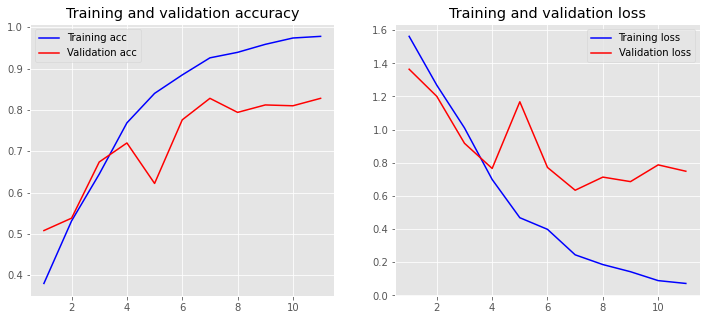

In [160]:

history = model.fit(X_train, y_train,
                    epochs=200,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=50,
                    callbacks=[callback]
                    )
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [161]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)
print(classification_report(emotion_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84        67
           1       0.88      0.81      0.84        57
           2       0.80      0.90      0.84       160
           3       0.67      0.55      0.60        44
           4       0.90      0.85      0.87       161
           5       0.60      0.55      0.57        11

    accuracy                           0.83       500
   macro avg       0.78      0.75      0.76       500
weighted avg       0.83      0.83      0.83       500

